In [10]:
import torch
import pandas as pd
from torch.optim import AdamW
from transformers import T5ForConditionalGeneration
import torch.nn as nn
from src.load_dataloader import initial_dataloader_vector_slicing
from tqdm import tqdm
from src.evaluation import initial_LSTM
from src.load_config import load_config
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

batch_size = 64
max_length = 64
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
torch.autograd.set_detect_anomaly(True)

In [11]:
_, tokenizer, device = load_config(max_length)
# import data
df = pd.read_csv('data_preprocess/datasets_combine.csv')
train_df, val_df,test_df, train_dataset,val_dataset, test_dataset,train_loader, val_loader, test_loader = initial_dataloader_vector_slicing(df, tokenizer, max_length,batch_size)
LSTM_model = initial_LSTM(tokenizer, device)

def call_tokenizer(text,max_length,device):
    output = tokenizer(text, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt').to(device)
    return output['input_ids'].to(device), output['attention_mask'].to(device)

def reparameterize(mean, log_variance):
    """Reparameterization trick to sample from the Normal distribution.
    
    Args:
    mean (torch.Tensor): Mean of the desired Normal distribution.
    log_variance (torch.Tensor): Log variance of the desired Normal distribution.

    Returns:
    A sample from the specified Normal distribution.
    """
    std = torch.exp(0.5 * log_variance)  # Get standard deviation from log variance
    eps = torch.randn_like(std)  # Sample a random tensor with shape like std from the standard Normal distribution
    return mean + eps * std  # Scale and shift eps

def classify_sentence(predicted_token_ids, lstm_model):
    # convert predicted_token_ids to text first
    texts1 = tokenizer.batch_decode(predicted_token_ids, skip_special_tokens=True)
    # convert back to token ids
    predicted_token_ids = tokenizer(texts1, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')['input_ids'].to(device)
    
    #predicted_token_ids = tokenizer(texts1, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')['input_ids'].to(device)

    # Initialize a tensor to store LSTM outputs
    lstm_outputs = torch.empty(size=(predicted_token_ids.shape[0], 2)).to(device)  # 2 for binary classification

    # Process each item in the batch
    for idx, token_ids in enumerate(predicted_token_ids):
        lstm_model.eval()
        with torch.no_grad():
            # Assuming lstm_model.predict returns a tensor of shape [1, 2] (probability for each class)
            lstm_output = lstm_model(token_ids.flatten())  # Modify this call according to your LSTM model's interface
            lstm_outputs[idx] = lstm_output

    return lstm_outputs

def kl_divergence(mean, log_var):
    return -0.5 * torch.sum(1 + log_var - mean**2 - log_var.exp())

class T5Encoder(nn.Module):
    def __init__(self, max_length):
        super(T5Encoder, self).__init__()
        # Load the pretrained T5-small model
        self.t5_encoder = T5ForConditionalGeneration.from_pretrained('t5-small',max_length = max_length)
        
    def forward(self, input_ids, attention_mask):
        # Pass the inputs through the T5-small model
        outputs = self.t5_encoder.encoder(input_ids=input_ids, attention_mask=attention_mask)
        
        return outputs
    
class T5Decoder(nn.Module):
    def __init__(self, max_length):
        super(T5Decoder, self).__init__()
        self.t5_decoder = T5ForConditionalGeneration.from_pretrained('t5-small',max_length = max_length)

    def forward(self, encoder_output, decoder_input_ids):
        # Pass the inputs through the T5-small model
        outputs = self.t5_decoder(decoder_input_ids = decoder_input_ids, encoder_outputs=encoder_output)
        
        return outputs.logits
    
class style_transform_model_encoder(nn.Module):
    def __init__(self, max_length):
        super(style_transform_model_encoder, self).__init__()
        self.content_encoder = T5Encoder(max_length)
        self.style_encoder = T5Encoder(max_length) 
        
    def forward(self, input_ids1 ,attention_mask1, input_ids2 ,attention_mask2):
        encoder_content_output1 = self.content_encoder(input_ids1,attention_mask1)
        encoder_style_output1 = self.style_encoder(input_ids1,attention_mask1)
        
        encoder_content_output2 = self.content_encoder(input_ids2,attention_mask2)
        encoder_style_output2 = self.style_encoder(input_ids2,attention_mask2)
        
        return encoder_content_output1, encoder_content_output2, encoder_style_output1, encoder_style_output2
    
class style_transform_model_decoder(nn.Module):
        def __init__(self, max_length):
            super(style_transform_model_decoder, self).__init__()
            self.decoder = T5Decoder(max_length)
            
        def forward(self, original_encoder_output1, original_encoder_output2, transfer_encoder_output1, transfer_encoder_output2, decoder_input_ids1, decoder_input_ids2):
            # reconstruct sentence
            sentence1_original = self.decoder(original_encoder_output1, decoder_input_ids1)
            sentence2_original = self.decoder(original_encoder_output2, decoder_input_ids2)
            
            sentence1_style2 = self.decoder(transfer_encoder_output1, decoder_input_ids1)
            sentence2_style1 = self.decoder(transfer_encoder_output2, decoder_input_ids2)
            
            return sentence1_original, sentence2_original, sentence1_style2, sentence2_style1

model_encoder = style_transform_model_encoder(max_length).to(device)
model_decoder = style_transform_model_decoder(max_length).to(device)

# load pth
model_encoder.load_state_dict(torch.load('T5_model_2encoder/model_encoder.pth'))
model_decoder.load_state_dict(torch.load('T5_model_2encoder/model_decoder.pth'))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


<All keys matched successfully>

In [12]:
# check test_loader length
print(len(test_loader))

3


In [13]:
model_encoder.eval()
model_decoder.eval() 

latent_vector1_content_list = []
latent_vector1_style_list = []

latent_vector2_content_list = []
latent_vector2_style_list = []

sentence1_original_latent_list = []
sentence2_original_latent_list = []
sentence1_style2_latent_list = []
sentence2_style1_latent_list = []


true_labels1 = []
pred_labels1 = []

true_labels2 = []
pred_labels2 = []

for batch in test_loader:
    input_ids1 = batch['input_ids1'].to(device)
    attention_mask1 = batch['attention_mask1'].to(device)
    labels1 = batch['sentence2_style'].to(device)
    
    input_ids2 = batch['input_ids2'].to(device)
    attention_mask2 = batch['attention_mask2'].to(device)
    labels2 = batch['sentence1_style'].to(device)
    
    with torch.no_grad():
        encoder_content_output1, encoder_content_output2, encoder_style_output1, encoder_style_output2 = model_encoder(input_ids1 ,attention_mask1, input_ids2 ,attention_mask2)
        
        content_hidden_state1 = encoder_content_output1.last_hidden_state
        style_hidden_state1 = encoder_style_output1.last_hidden_state
        content_hidden_state2 = encoder_content_output2.last_hidden_state
        style_hidden_state2 = encoder_style_output2.last_hidden_state
        
        sentence1_original_latent = reparameterize(content_hidden_state1, style_hidden_state1)
        sentence2_original_latent = reparameterize(content_hidden_state2, style_hidden_state2)
        original_encoder_output1 = encoder_content_output1
        original_encoder_output1.hidden_states = sentence1_original_latent
        original_encoder_output2 = encoder_content_output2
        original_encoder_output2.hidden_states = sentence2_original_latent
        
        # style transfer the sentence
        sentence1_style2_latent = reparameterize(content_hidden_state1, style_hidden_state2)
        sentence2_style1_latent = reparameterize(content_hidden_state2, style_hidden_state1)
        transfer_encoder_output1 = encoder_content_output1
        transfer_encoder_output1.hidden_states = sentence1_style2_latent
        transfer_encoder_output2 = encoder_content_output2
        transfer_encoder_output2.hidden_states = sentence2_style1_latent
        
        decoder_input = tokenizer('', padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')['input_ids'].to(device)
        decoder_input = decoder_input.repeat(input_ids1.shape[0],1)
        
        # call decoder
        sentence1_original, sentence2_original, sentence1_style2, sentence2_style1 = model_decoder(original_encoder_output1, original_encoder_output2, transfer_encoder_output1, transfer_encoder_output2, decoder_input, decoder_input)
        
        # save hidden_state
        content_hidden_state1 = torch.mean(content_hidden_state1, dim=1)
        style_hidden_state1 = torch.mean(style_hidden_state1, dim=1)
        content_hidden_state2 = torch.mean(content_hidden_state2, dim=1)
        style_hidden_state2 = torch.mean(style_hidden_state2, dim=1)
        latent_vector1_content_list += content_hidden_state1.tolist()
        latent_vector1_style_list += style_hidden_state1.tolist()
        latent_vector2_content_list += content_hidden_state2.tolist()
        latent_vector2_style_list += style_hidden_state2.tolist()
        
        sentence1_original_latent = torch.mean(sentence1_original_latent, dim=1)
        sentence2_original_latent = torch.mean(sentence2_original_latent, dim=1)
        sentence1_style2_latent = torch.mean(sentence1_style2_latent, dim=1)
        sentence2_style1_latent = torch.mean(sentence2_style1_latent, dim=1)
        sentence1_original_latent_list += sentence1_original_latent.tolist()
        sentence2_original_latent_list += sentence2_original_latent.tolist()
        sentence1_style2_latent_list += sentence1_style2_latent.tolist()
        sentence2_style1_latent_list += sentence2_style1_latent.tolist()
        
        # classification loss
        sentence1_style1_copy = sentence1_style2.clone()
        sentence2_style2_copy = sentence2_style1.clone() 
        
        sentence1_style1_copy = torch.argmax(sentence1_style1_copy, dim=-1).to(device)
        sentence2_style2_copy = torch.argmax(sentence2_style2_copy, dim=-1).to(device)
        
        Predicted_labels1 = classify_sentence(sentence1_style1_copy, LSTM_model)
        Predicted_labels2 = classify_sentence(sentence2_style2_copy, LSTM_model)
        
        # save labels
        true_labels1 += labels1.tolist()
        true_labels2 += labels2.tolist()
        pred_labels1 += Predicted_labels1.tolist()
        pred_labels2 += Predicted_labels2.tolist()
        
latent_vector1_content_list = np.array(latent_vector1_content_list)
latent_vector1_content_list = np.array(latent_vector1_content_list).reshape(-1, latent_vector1_content_list.shape[1])

latent_vector1_style_list = np.array(latent_vector1_style_list)
latent_vector1_style_list = np.array(latent_vector1_style_list).reshape(-1, latent_vector1_style_list.shape[1])

latent_vector2_content_list = np.array(latent_vector2_content_list)
latent_vector2_content_list = np.array(latent_vector2_content_list).reshape(-1, latent_vector2_content_list.shape[1])

latent_vector2_style_list = np.array(latent_vector2_style_list)
latent_vector2_style_list = np.array(latent_vector2_style_list).reshape(-1, latent_vector2_style_list.shape[1])

latent_vector_content_list = np.concatenate((latent_vector1_content_list, latent_vector2_content_list), axis=0)
latent_vector_style_list = np.concatenate((latent_vector1_style_list, latent_vector2_style_list), axis=0)

sentence1_original_latent_list = np.array(sentence1_original_latent_list)
sentence1_original_latent_list = np.array(sentence1_original_latent_list).reshape(-1, sentence1_original_latent_list.shape[1])

sentence2_original_latent_list = np.array(sentence2_original_latent_list)
sentence2_original_latent_list = np.array(sentence2_original_latent_list).reshape(-1, sentence2_original_latent_list.shape[1])

sentence1_style2_latent_list = np.array(sentence1_style2_latent_list)
sentence1_style2_latent_list = np.array(sentence1_style2_latent_list).reshape(-1, sentence1_style2_latent_list.shape[1])

sentence2_style1_latent_list = np.array(sentence2_style1_latent_list)
sentence2_style1_latent_list = np.array(sentence2_style1_latent_list).reshape(-1, sentence2_style1_latent_list.shape[1])

true_labels = true_labels1 + true_labels2
pred_labels = pred_labels1 + pred_labels2

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)
print("Evaluation done!")

c:\Users\Ene\Desktop\CS505_github\Natural-Language_Project\src\load_dataloader.py:179: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids1': torch.tensor(item['input_ids1'], dtype=torch.long).squeeze(0),
c:\Users\Ene\Desktop\CS505_github\Natural-Language_Project\src\load_dataloader.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids2': torch.tensor(item['input_ids2'], dtype=torch.long).squeeze(0),
c:\Users\Ene\Desktop\CS505_github\Natural-Language_Project\src\load_dataloader.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

Evaluation done!


In [14]:
for index in range(5):
    
    text_pair = test_df.iloc[index]
    text1 = text_pair['sentence']
    text2 = text_pair['target_text']

    text_id1 = tokenizer(text1, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt').to(device)
    text_id2 = tokenizer(text2, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt').to(device)

    encoder_content_output1, encoder_content_output2, encoder_style_output1, encoder_style_output2 = model_encoder(text_id1['input_ids'] ,text_id1["attention_mask"], text_id2['input_ids'] ,text_id2["attention_mask"])
    
    content_hidden_state1 = encoder_content_output1.last_hidden_state
    style_hidden_state1 = encoder_style_output1.last_hidden_state
    content_hidden_state2 = encoder_content_output2.last_hidden_state
    style_hidden_state2 = encoder_style_output2.last_hidden_state
    
    sentence1_original_latent = reparameterize(content_hidden_state1, style_hidden_state1)
    sentence2_original_latent = reparameterize(content_hidden_state2, style_hidden_state2)
    original_encoder_output1 = encoder_content_output1
    original_encoder_output1.hidden_states = sentence1_original_latent
    original_encoder_output2 = encoder_content_output2
    original_encoder_output2.hidden_states = sentence2_original_latent
    
    # style transfer the sentence
    sentence1_style2_latent = reparameterize(content_hidden_state1, style_hidden_state2)
    sentence2_style1_latent = reparameterize(content_hidden_state2, style_hidden_state1)
    transfer_encoder_output1 = encoder_content_output1
    transfer_encoder_output1.hidden_states = sentence1_style2_latent
    transfer_encoder_output2 = encoder_content_output2
    transfer_encoder_output2.hidden_states = sentence2_style1_latent
    
    # call decoder
    decoder_input = tokenizer('', padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')['input_ids'].to(device)
    sentence1_original, sentence2_original, sentence1_style2, sentence2_style1 = model_decoder(original_encoder_output1, original_encoder_output2, transfer_encoder_output1, transfer_encoder_output2, decoder_input, decoder_input)
    
    sentence1_original = torch.argmax(sentence1_original, dim=-1).to(device).flatten()
    sentence2_original = torch.argmax(sentence2_original, dim=-1).to(device).flatten()
    sentence1_style2 = torch.argmax(sentence1_style2, dim=-1).to(device).flatten()
    sentence2_style1 = torch.argmax(sentence2_style1, dim=-1).to(device).flatten()
    
    text1_recon = tokenizer.decode(sentence1_original, skip_special_tokens=True)
    text2_recon = tokenizer.decode(sentence2_original, skip_special_tokens=True)
    new_text1 = tokenizer.decode(sentence1_style2, skip_special_tokens=True)
    new_text2 = tokenizer.decode(sentence2_style1, skip_special_tokens=True)

    print("original text1: ", text1)
    print("target text: ", text2)
    print("recon text1: ", text1_recon)
    print("transfer text1: ", new_text1)
    print("--------------------------------------------------")
    print("original text2: ", text2)
    print("target text: ", text1)
    print("recon text2: ", text2_recon)
    print("transfer text2: ", new_text2)
    print("--------------------------------------------------")

original text1:  One word more; I charge theeThat thou attend me: thou dost here usurpThe name thou owest not; and hast put thyselfUpon this island as a spy, to win itFrom me, the lord on't
target text:  Nebraska company grades employees on how healthy they are
recon text1:  One word more; charge charge charge theThatThatThatthou attend attend attend attendhouhouhouhouhouhouttt us us ust        ;;;ttttttttttt        to to to to to
transfer text1:  One word more; charge charge charge theThatThatThatthou attend attend attend attendhouhouhouhouhouhouttt us us ust        ;;;ttttttttttt        to to to to to
--------------------------------------------------
original text2:  Nebraska company grades employees on how healthy they are
target text:  One word more; I charge theeThat thou attend me: thou dost here usurpThe name thou owest not; and hast put thyselfUpon this island as a spy, to win itFrom me, the lord on't
recon text2:  Nebraska company grades employees employees how how how they a

ROC AUC: 0.0352


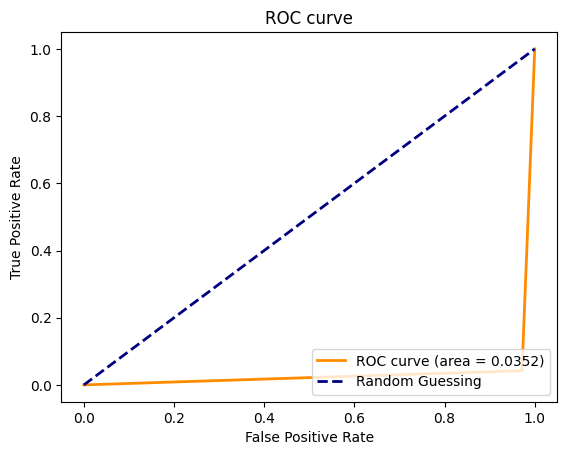

In [15]:
# roc curve for true_labels and pred_labels
from sklearn.metrics import roc_curve, auc
pred_labels_argmax = np.argmax(pred_labels, axis=1)
fpr, tpr, thresholds = roc_curve(true_labels, pred_labels_argmax)
roc_auc = auc(fpr, tpr)
print("ROC AUC: {0:.4f}".format(roc_auc))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

# calculate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(true_labels, pred_labels_argmax)

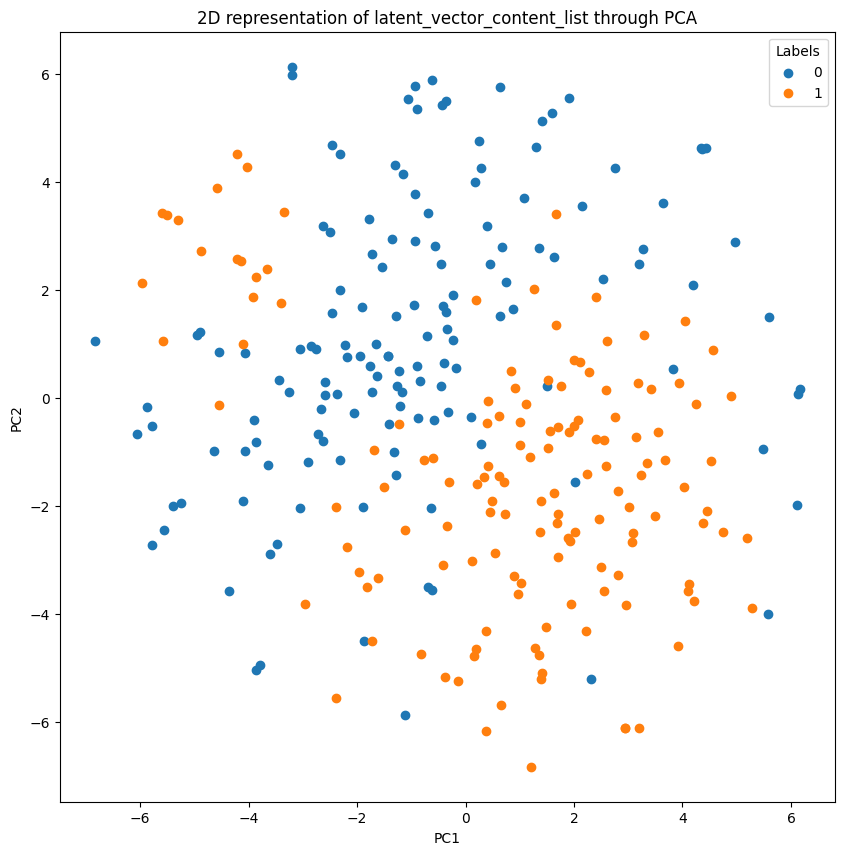

In [16]:
from sklearn.manifold import TSNE
# Perform TSNE
pca = TSNE(n_components=2)
latent_vector_content_list_2D = pca.fit_transform(latent_vector_content_list)

# Plot 2D representation of latent_vector_content_list through PCA
plt.figure(figsize=(10, 10))

# Get unique labels
unique_labels = set(true_labels)

# Plot each class with a different color and label
for label in unique_labels:
    # Select indices corresponding to the current label
    indices = [i for i, l in enumerate(true_labels) if l == label]

    # Scatter plot for each individual class
    plt.scatter(latent_vector_content_list_2D[indices, 0], latent_vector_content_list_2D[indices, 1], label=label)

# Add labels and title
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('2D representation of latent_vector_content_list through PCA')

# Add legend
plt.legend(title='Labels')

# Show plot
plt.show()


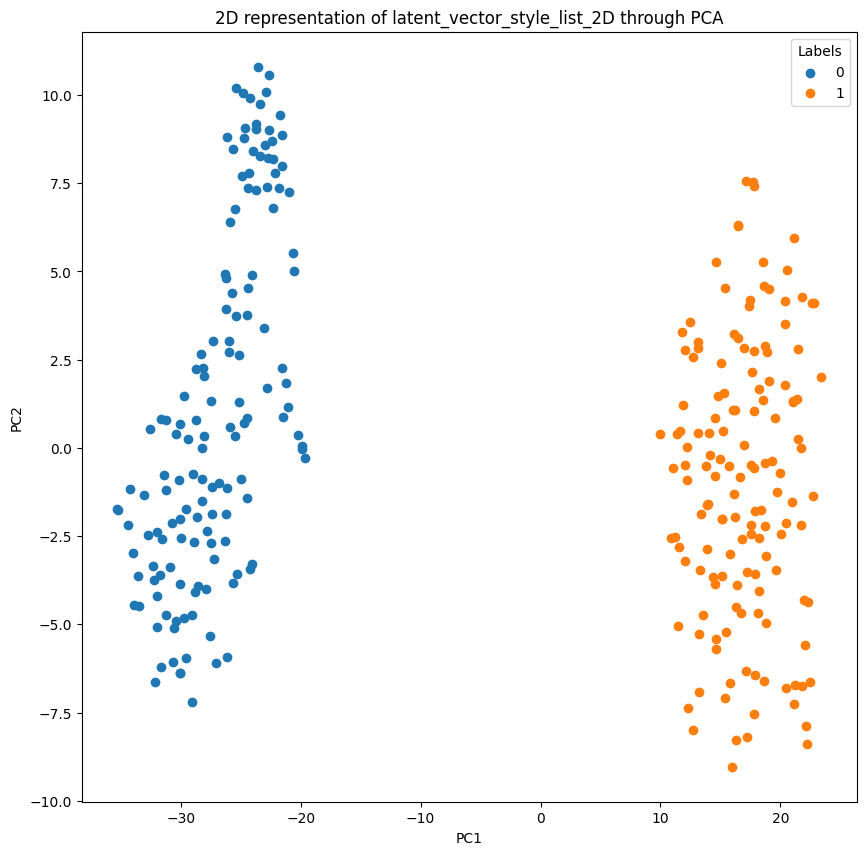

In [17]:
# Perform TSNE on latent_vector_style_list
pca = TSNE(n_components=2)
latent_vector_style_list_2D = pca.fit_transform(latent_vector_style_list)

# Plot 2D representation of latent_vector_style_list through PCA
plt.figure(figsize=(10, 10))

# Get unique labels
unique_labels = set(true_labels)

# Plot each class with a different color and label
for label in unique_labels:
    # Select indices corresponding to the current label
    indices = [i for i, l in enumerate(true_labels) if l == label]

    # Scatter plot for each individual class
    plt.scatter(latent_vector_style_list_2D[indices, 0], latent_vector_style_list_2D[indices, 1], label=label)

# Add labels and title
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('2D representation of latent_vector_style_list_2D through PCA')

# Add legend
plt.legend(title='Labels')

# Show plot
plt.show()


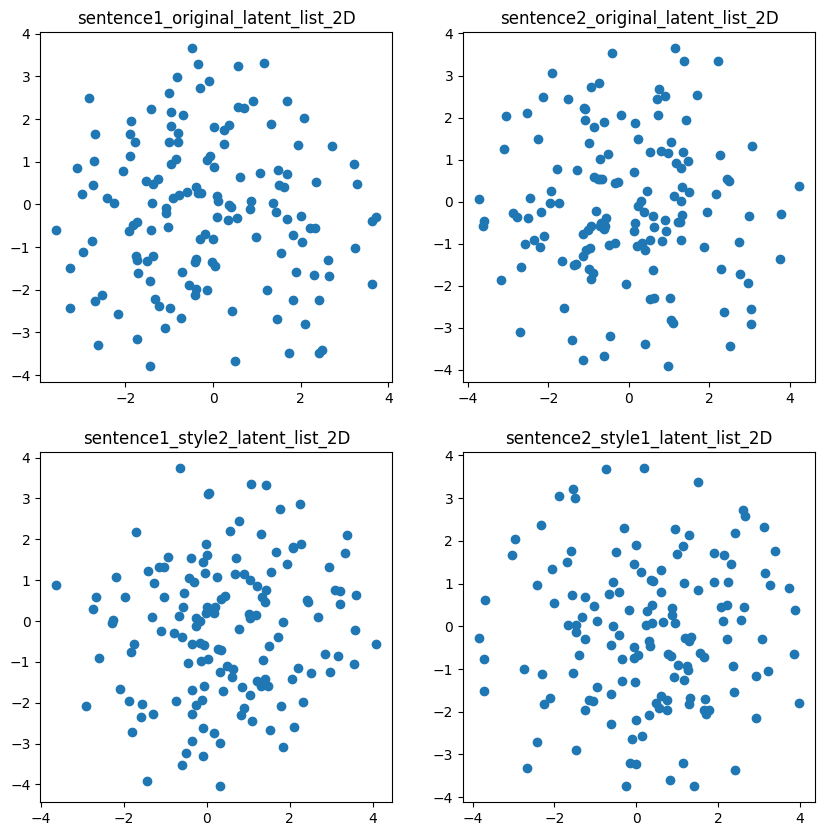

In [18]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Assuming sentence1_original_latent_list, etc., are your arrays of latent vectors

# Combine all latent vectors into a single dataset
combined_latent_vectors = np.concatenate([
    sentence1_original_latent_list, 
    sentence2_original_latent_list, 
    sentence1_style2_latent_list, 
    sentence2_style1_latent_list
])

# Apply t-SNE to the combined dataset
pca = TSNE(n_components=2)
combined_latent_vectors_2D = pca.fit_transform(combined_latent_vectors)

# Split the transformed data back into separate sets
num_vectors = len(sentence1_original_latent_list)
sentence1_original_latent_list_2D = combined_latent_vectors_2D[:num_vectors]
sentence2_original_latent_list_2D = combined_latent_vectors_2D[num_vectors:2*num_vectors]
sentence1_style2_latent_list_2D = combined_latent_vectors_2D[2*num_vectors:3*num_vectors]
sentence2_style1_latent_list_2D = combined_latent_vectors_2D[3*num_vectors:]

# Plot 2D representations in four separate plots
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.scatter(sentence1_original_latent_list_2D[:, 0], sentence1_original_latent_list_2D[:, 1])
plt.title('sentence1_original_latent_list_2D')
plt.subplot(2, 2, 2)
plt.scatter(sentence2_original_latent_list_2D[:, 0], sentence2_original_latent_list_2D[:, 1])
plt.title('sentence2_original_latent_list_2D')
plt.subplot(2, 2, 3)
plt.scatter(sentence1_style2_latent_list_2D[:, 0], sentence1_style2_latent_list_2D[:, 1])
plt.title('sentence1_style2_latent_list_2D')
plt.subplot(2, 2, 4)
plt.scatter(sentence2_style1_latent_list_2D[:, 0], sentence2_style1_latent_list_2D[:, 1])
plt.title('sentence2_style1_latent_list_2D')
plt.show()
